# SINC3-PLOT


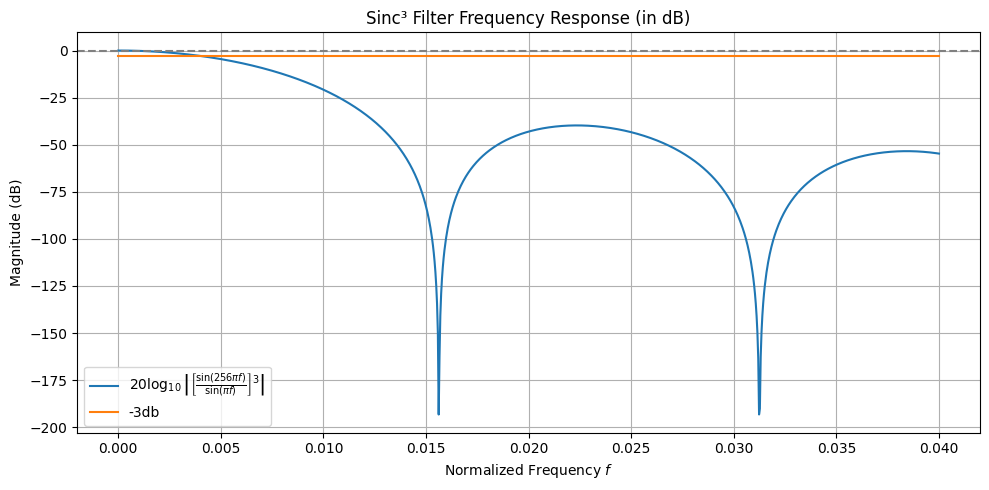

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 設定抽取率 R
R = 64

f = np.linspace(0, 0.04, 1000)
epsilon = 1e-10
pi_f = np.pi * f
pi_f[pi_f == 0] = epsilon 

H = (np.sin(R * pi_f) / np.sin(pi_f)) ** 3
H = np.abs(H)
H[H == 0] = epsilon
H_dB = 20 * (np.log10(H) - np.log10(R ** 3))

S = [-3 for x in range(len(f))]

plt.figure(figsize=(10, 5))
plt.plot(f, H_dB, label=r'$20\log_{10} \left| \left[\frac{\sin(256\pi f)}{\sin(\pi f)} \right]^3 \right|$')
plt.plot(f, S, label='-3db')
plt.title('Sinc³ Filter Frequency Response (in dB)')
plt.xlabel('Normalized Frequency $f$')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which='both')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

截止頻率 f_c ≈ 0.004093 (以輸出取樣率為單位)


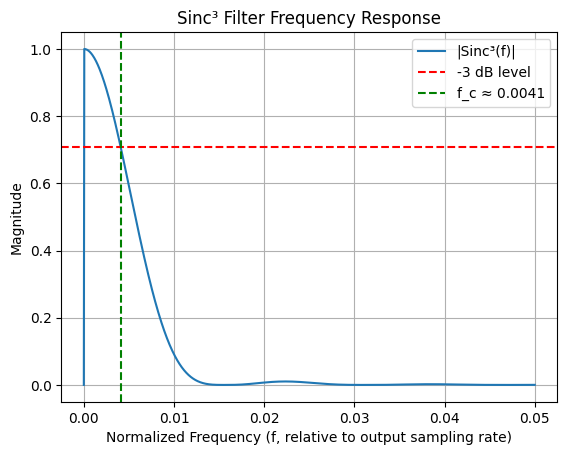

In [5]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# 設定抽取率 R
R = 64

# 定義 sinc^3 頻率響應的函數
def sinc3_response(f):
    numerator = np.sin(np.pi * f * R)
    denominator = np.sin(np.pi * f) + 1e-12  
    magnitude_responce = np.abs(numerator / denominator) ** 3 
    return magnitude_responce / ( R ** 3)

# 目標函數：H(f) - 1/sqrt(2)
def target_func(f):
    return sinc3_response(f) - 1 / np.sqrt(2)

# 使用 fsolve 找解：初始猜測設在 1/2R 附近
initial_guess = 1 / (2 * R)
fc_solution = fsolve(target_func, initial_guess)[0]

print(f"截止頻率 f_c ≈ {fc_solution:.6f} (以輸出取樣率為單位)")

frequencies = np.linspace(0, 0.05, 1000)
response = sinc3_response(frequencies)

plt.plot(frequencies, response, label='|Sinc³(f)|')
plt.axhline(1/np.sqrt(2), color='red', linestyle='--', label='-3 dB level')
plt.axvline(fc_solution, color='green', linestyle='--', label=f'f_c ≈ {fc_solution:.4f}')
plt.title("Sinc³ Filter Frequency Response")
plt.xlabel("Normalized Frequency (f, relative to output sampling rate)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()


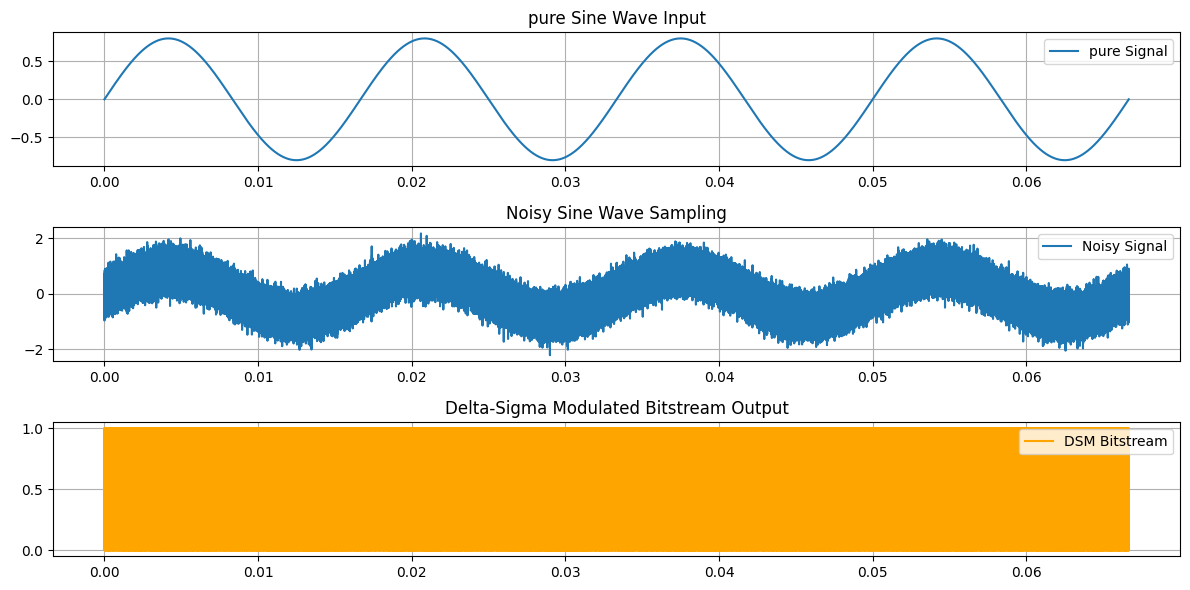

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ==== 參數設定 ====
signal_frequency = 60        # 訊號頻率
sampling_frequency = 10 * pow(10, 6)      # 取樣頻率
num_periods = 4                             # 取樣幾個週期
total_points = int(sampling_frequency / signal_frequency * num_periods) # 總取樣點數
noise_std = 0.3                           # 高斯雜訊標準差

# ==== 時間軸 ====
t = np.linspace(0, 1 / sampling_frequency * total_points, total_points)

# ==== 輸入訊號 ====
omega = 2 * np.pi * signal_frequency
pure_signal = 0.8 * np.sin(omega * t)
noisy_signal = pure_signal + np.random.normal(loc=0.0, scale=noise_std, size=total_points)

#verilog專案目錄
workDirectory = "c:/iDesign/isinc3/";

# ==== 第一階 Delta-Sigma Modulator ====
integrator = 0
feedback = 0
bitstream = []

for x in noisy_signal:  
    integrator += x - feedback
    if integrator >= 0:
        bit = 1
        feedback = 1
    else:
        bit = 0
        feedback = -1
    bitstream.append(bit)

# ==== 輸出 bitstream 到 TXT 檔案 ====
with open(workDirectory + "delta_sigma_output.txt", "w") as f:
    time_interval = round(1 / sampling_frequency * pow(10, 9) / 2) 
    time_stop = time_interval * total_points * 2
    f.write(f"{total_points}\n{time_interval}\n{time_stop}\n")
    for bit in bitstream:
        f.write(f"{bit}\n")

t_bitstream = t[:len(bitstream)]  

# ==== 畫圖 ====
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t, pure_signal, label="pure Signal")
plt.title("pure Sine Wave Input")
plt.grid(True)
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(t, noisy_signal, label="Noisy Signal")
plt.title("Noisy Sine Wave Sampling")
plt.grid(True)
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.step(t_bitstream, bitstream, where='mid', label="DSM Bitstream", color='orange')
plt.title("Delta-Sigma Modulated Bitstream Output")
plt.grid(True)
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.show()
